## The objective of this analysis is to explore the dataset received from Apprentice Chef and design a Machine Learning Model that best predicts which customers would subscribe to the 'Halfway There' promotion.


**Importing Packages and Loading the Dataset**

In [1]:
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # essential graphical output
import seaborn as sns                                # enhanced graphical output
import statsmodels.formula.api as smf                # regression modeling
from sklearn.model_selection import train_test_split # train_test_split
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from sklearn.ensemble import AdaBoostClassifier      # ADA booster
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

file = 'Apprentice_Chef_Dataset.xlsx'

original_df = pd.read_excel(file) # reading in the dataset

D:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


**Creating user-defined functions to make the analysis easier**

In [2]:
########################## USER-DEFINED FUNCTIONS ##########################

########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=802,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 802
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(X_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(X_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(X_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    

########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

**Initial scan of the dataset**

In [3]:
original_df.head(n=10) # getting an initial look at the dataset

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0,1880.0,1,Addam Osgrey,addam.osgrey@passport.com,Addam,Osgrey,118,4,7,5,...,2,1,0,90,165.8,6,1,3,11,0
1,1495.0,1,Aegon Blackfyre,aegon.blackfyre@jnj.com,Aegon,Blackfyre,44,3,6,3,...,4,1,0,90,150.5,4,1,3,13,90
2,2572.5,1,Aegon Frey (son of Aenys),aegon.frey.(son.of.aenys)@gmail.com,Aegon,Frey,38,1,5,3,...,0,0,0,80,99.6,3,0,3,12,0
3,1647.0,1,Aegon Targaryen (son of Rhaegar),aegon.targaryen.(son.of.rhaegar)@ibm.com,Aegon,Targaryen,76,3,8,10,...,4,0,0,90,125.0,3,0,3,13,0
4,1923.0,1,Aegon V Targaryen,aegon.v.targaryen@goldmansacs.com,Aegon,V Targaryen,65,3,6,9,...,4,1,0,90,135.3,3,1,3,13,253
5,1250.0,1,Aegor Rivers,aegor.rivers@gmail.com,Aegor,Rivers,57,4,6,2,...,5,0,0,70,91.2,3,1,2,17,0
6,4665.0,1,Aelinor Penrose,aelinor.penrose@homedepot.com,Aelinor,Penrose,106,3,10,8,...,3,0,0,70,263.3,6,2,4,10,705
7,1690.0,1,Aemma Arryn,aemma.arryn@yahoo.com,Aemma,Arryn,122,6,8,10,...,3,0,0,70,160.0,5,1,3,13,0
8,1710.0,1,Aemon Rivers,aemon.rivers@caterpillar.com,Aemon,Rivers,46,4,5,10,...,10,1,1,70,170.1,4,2,3,12,0
9,1770.0,1,Aggar,aggar@protonmail.com,Aggar,Aggar,58,4,6,5,...,7,1,1,90,191.3,7,1,3,12,0


In [4]:
original_df.info() # understanding features of the dataset
                   # from this, I can tell that there are missing values only in the FAMILY_NAME column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REVENUE                       1946 non-null   float64
 1   CROSS_SELL_SUCCESS            1946 non-null   int64  
 2   NAME                          1946 non-null   object 
 3   EMAIL                         1946 non-null   object 
 4   FIRST_NAME                    1946 non-null   object 
 5   FAMILY_NAME                   1899 non-null   object 
 6   TOTAL_MEALS_ORDERED           1946 non-null   int64  
 7   UNIQUE_MEALS_PURCH            1946 non-null   int64  
 8   CONTACTS_W_CUSTOMER_SERVICE   1946 non-null   int64  
 9   PRODUCT_CATEGORIES_VIEWED     1946 non-null   int64  
 10  AVG_TIME_PER_SITE_VISIT       1946 non-null   float64
 11  MOBILE_NUMBER                 1946 non-null   int64  
 12  CANCELLATIONS_BEFORE_NOON     1946 non-null   int64  
 13  CAN

In [5]:
# Filling in the NULL values with 'Unknown' just in case the NULL values create any problems in the analysis ahead 

original_df['FAMILY_NAME'] = original_df['FAMILY_NAME'].fillna('Unknown')

In [6]:
# Since the objective of the analysis is to understand how Apprentice Chef
# can diversify their revenue stream, I am adding some new features.

# Adding new features to further understand the dataset (Part I)

original_df['PRICE_PER_ORDER'] = original_df['REVENUE']/original_df['TOTAL_MEALS_ORDERED']
# with this, I want to understand how much each person is paying per order

In [7]:
original_df.loc[:,'REVENUE':'CANCELLATIONS_AFTER_NOON'].describe().round(2) 
# looking at descriptive statistics of first half of data to categorize

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON
count,1946.00,1946.00,1946.00,1946.0,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00
mean,2107.29,0.68,74.63,4.9,6.98,5.38,99.60,0.88,1.40,0.17
std,1138.29,0.47,55.31,2.5,2.28,3.04,62.34,0.33,1.55,0.43
min,131.00,0.00,11.00,1.0,1.00,1.00,10.33,0.00,0.00,0.00
25%,1350.00,0.00,39.00,3.0,5.00,3.00,72.00,1.00,0.00,0.00
50%,1740.00,1.00,60.00,5.0,7.00,5.00,94.16,1.00,1.00,0.00
75%,2670.00,1.00,95.00,7.0,8.00,8.00,117.29,1.00,2.00,0.00
max,8793.75,1.00,493.00,19.0,18.00,10.00,1645.60,1.00,13.00,3.00


In [8]:
original_df.loc[:,'TASTES_AND_PREFERENCES':].describe().round(2) 
# looking at descriptive statistics of second half of data to categorize 

,TASTES_AND_PREFERENCES,MOBILE_LOGINS,PC_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED,PRICE_PER_ORDER
count,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00,1946.00
mean,0.71,5.52,1.48,11.33,1.49,2.97,0.36,0.11,35.41,150.56,4.44,0.60,2.79,13.51,106.43,36.50
std,0.45,0.58,0.53,13.57,2.32,2.74,0.48,0.32,26.58,49.45,1.55,0.64,0.76,2.33,181.01,19.36
min,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.40,0.00,0.00,1.00,5.00,0.00,9.78
25%,0.00,5.00,1.00,1.00,0.00,1.00,0.00,0.00,10.00,114.40,3.00,0.00,2.00,12.00,0.00,22.16
50%,1.00,6.00,1.00,7.00,0.00,2.00,0.00,0.00,30.00,145.60,4.00,1.00,3.00,13.00,0.00,33.56
75%,1.00,6.00,2.00,13.00,3.00,4.00,1.00,0.00,60.00,173.78,5.00,1.00,3.00,15.00,174.00,45.00
max,1.00,7.00,3.00,52.00,9.00,19.00,1.00,1.00,90.00,564.20,11.00,3.00,5.00,19.00,1600.00,153.12


In [9]:
## Categorization of data 

"""
# CONTINUOUS OR INTERVAL

REVENUE
AVG_TIME_PER_SITE_VISIT
AVG_PREP_VID_TIME
AVG_CLICKS_PER_VISIT
FOLLOWED_RECOMMENDATIONS_PCT
PRICE_PER_ORDER


# BINARY

CROSS_SELL_SUCCESS
MOBILE_NUMBER
PACKAGE_LOCKER
REFRIGERATED_LOCKER
TASTES_AND_PREFERENCES


# COUNT

TOTAL_MEALS_ORDERED
UNIQUE_MEALS_PURCH
CONTACTS_W_CUSTOMER_SERVICE
PRODUCT_CATEGORIES_VIEWED
CANCELLATIONS_BEFORE_NOON
CANCELLATIONS_AFTER_NOON
MOBILE_LOGINS
PC_LOGINS
WEEKLY_PLAN
EARLY_DELIVERIES
LATE_DELIVERIES
LARGEST_ORDER_SIZE
MASTER_CLASSES_ATTENDED
TOTAL_PHOTOS_VIEWED


# DISCRETE
LARGEST_ORDER_SIZE
MEDIAN_MEAL_RATING
"""

'\n# CONTINUOUS OR INTERVAL\n\nREVENUE\nAVG_TIME_PER_SITE_VISIT\nAVG_PREP_VID_TIME\nAVG_CLICKS_PER_VISIT\nFOLLOWED_RECOMMENDATIONS_PCT\nPRICE_PER_ORDER\n\n\n# BINARY\n\nCROSS_SELL_SUCCESS\nMOBILE_NUMBER\nPACKAGE_LOCKER\nREFRIGERATED_LOCKER\nTASTES_AND_PREFERENCES\n\n\n# COUNT\n\nTOTAL_MEALS_ORDERED\nUNIQUE_MEALS_PURCH\nCONTACTS_W_CUSTOMER_SERVICE\nPRODUCT_CATEGORIES_VIEWED\nCANCELLATIONS_BEFORE_NOON\nCANCELLATIONS_AFTER_NOON\nMOBILE_LOGINS\nPC_LOGINS\nWEEKLY_PLAN\nEARLY_DELIVERIES\nLATE_DELIVERIES\nLARGEST_ORDER_SIZE\nMASTER_CLASSES_ATTENDED\nTOTAL_PHOTOS_VIEWED\n\n\n# DISCRETE\nLARGEST_ORDER_SIZE\nMEDIAN_MEAL_RATING\n'

In [10]:
# Obtaining counts of binary variables to further understand the data:

print(f"""

{original_df['CROSS_SELL_SUCCESS'].value_counts().sort_index()}


{original_df['MOBILE_NUMBER'].value_counts().sort_index()}


{original_df['PACKAGE_LOCKER'].value_counts().sort_index()}


{original_df['REFRIGERATED_LOCKER'].value_counts().sort_index()}


{original_df['TASTES_AND_PREFERENCES'].value_counts().sort_index()}

""")



0     625
1    1321
Name: CROSS_SELL_SUCCESS, dtype: int64


0     238
1    1708
Name: MOBILE_NUMBER, dtype: int64


0    1255
1     691
Name: PACKAGE_LOCKER, dtype: int64


0    1726
1     220
Name: REFRIGERATED_LOCKER, dtype: int64


0     556
1    1390
Name: TASTES_AND_PREFERENCES, dtype: int64




**Exploratory Data Analysis to design outliers and thresholds**

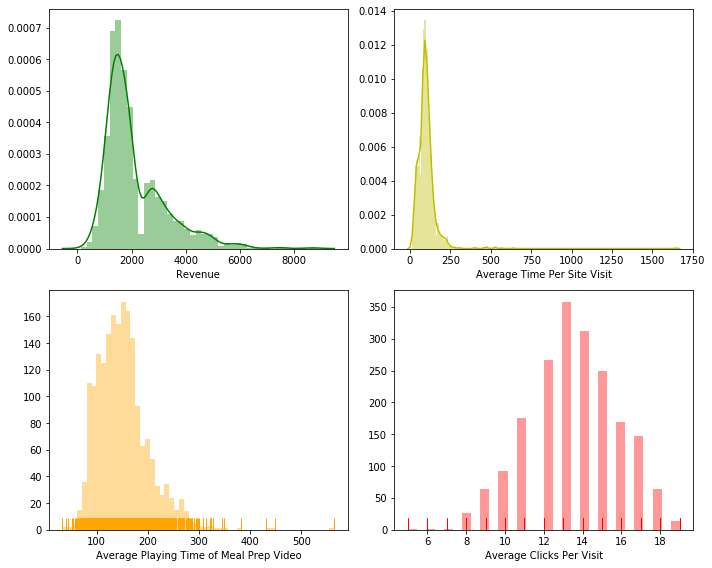

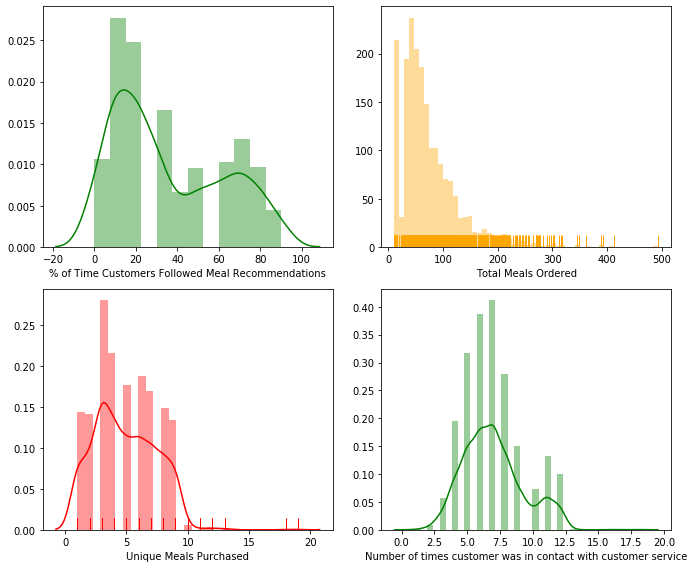

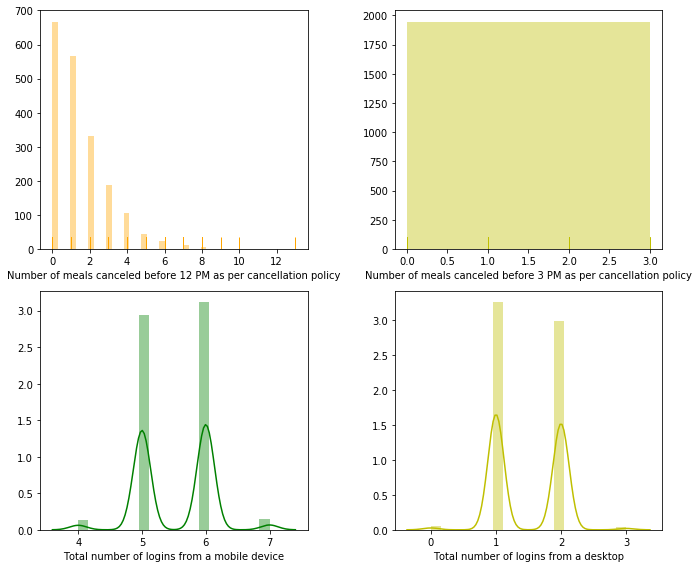

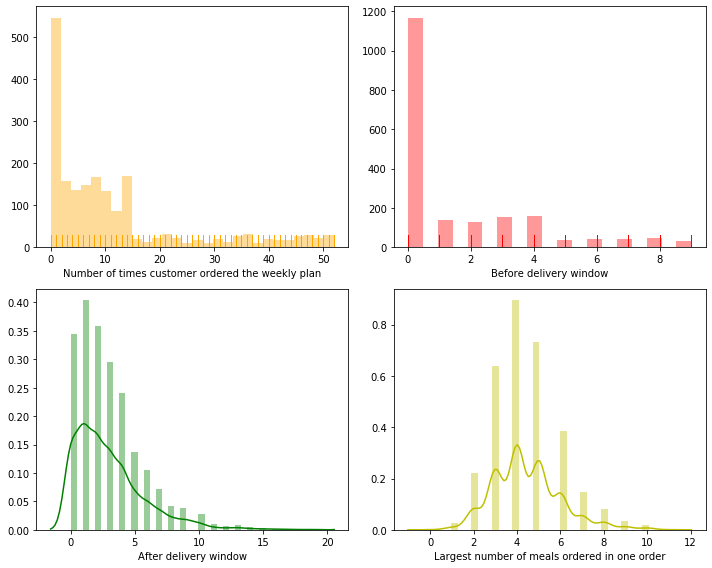

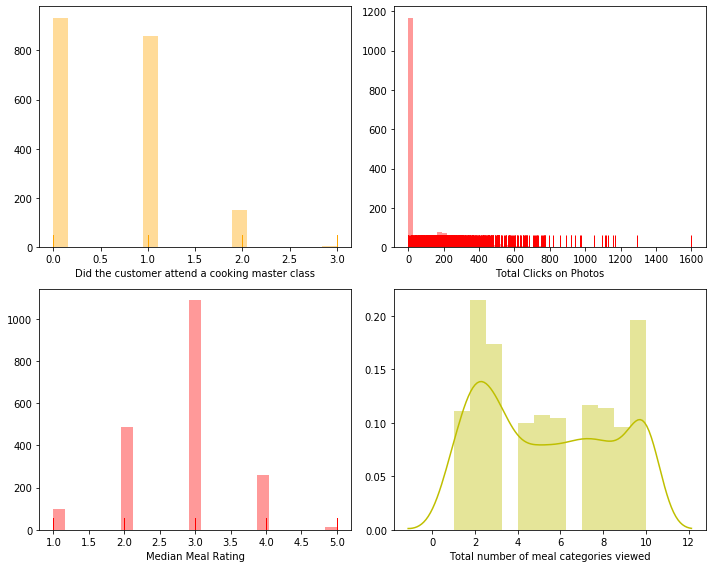

In [11]:
########################################
# Exploratory data analysis (Histograms)
########################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['REVENUE'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Revenue')

#######################################

plt.subplot(2, 2, 2)
sns.distplot(original_df['AVG_TIME_PER_SITE_VISIT'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Average Time Per Site Visit')

#######################################

plt.subplot(2, 2, 3)
sns.distplot(original_df['AVG_PREP_VID_TIME'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Average Playing Time of Meal Prep Video')

#######################################

plt.subplot(2, 2, 4)
sns.distplot(original_df['AVG_CLICKS_PER_VISIT'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('Average Clicks Per Visit')
plt.tight_layout()
plt.show()

#######################################
#######################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['FOLLOWED_RECOMMENDATIONS_PCT'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('% of Time Customers Followed Meal Recommendations')

#######################################

plt.subplot(2, 2, 2)
sns.distplot(original_df['TOTAL_MEALS_ORDERED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Total Meals Ordered')

#######################################

plt.subplot(2, 2, 3)
sns.distplot(original_df['UNIQUE_MEALS_PURCH'],
             bins  = 'fd',
             kde   = True,
             rug   = True,
             color = 'r')
plt.xlabel('Unique Meals Purchased')

#######################################

plt.subplot(2, 2, 4)
sns.distplot(original_df['CONTACTS_W_CUSTOMER_SERVICE'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Number of times customer was in contact with customer service')
plt.tight_layout()
plt.show()

#######################################
#######################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['CANCELLATIONS_BEFORE_NOON'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Number of meals canceled before 12 PM as per cancellation policy')

#######################################

plt.subplot(2, 2, 2)
sns.distplot(original_df['CANCELLATIONS_AFTER_NOON'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'y')
plt.xlabel('Number of meals canceled before 3 PM as per cancellation policy')

#######################################

plt.subplot(2, 2, 3)
sns.distplot(original_df['MOBILE_LOGINS'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('Total number of logins from a mobile device')

#######################################

plt.subplot(2, 2, 4)
sns.distplot(original_df['PC_LOGINS'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Total number of logins from a desktop')
plt.tight_layout()
plt.show()

#######################################
#######################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['WEEKLY_PLAN'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Number of times customer ordered the weekly plan')

#######################################

plt.subplot(2, 2, 2)
sns.distplot(original_df['EARLY_DELIVERIES'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('Before delivery window')

#######################################

plt.subplot(2, 2, 3)
sns.distplot(original_df['LATE_DELIVERIES'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('After delivery window')

#######################################

plt.subplot(2, 2, 4)
sns.distplot(original_df['LARGEST_ORDER_SIZE'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Largest number of meals ordered in one order')
plt.tight_layout()
plt.show()

#######################################
#######################################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(original_df['MASTER_CLASSES_ATTENDED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('Did the customer attend a cooking master class')

#######################################

plt.subplot(2, 2, 2)
sns.distplot(original_df['TOTAL_PHOTOS_VIEWED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('Total Clicks on Photos')

#######################################

plt.subplot(2, 2, 3)
sns.distplot(original_df['MEDIAN_MEAL_RATING'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('Median Meal Rating')

#######################################

plt.subplot(2, 2, 4)
sns.distplot(original_df['PRODUCT_CATEGORIES_VIEWED'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('Total number of meal categories viewed')
plt.tight_layout()
plt.show()

#######################################
#######################################

In [12]:
# Setting outlier thresholds:

REVENUE_hi = 2500
AVG_TIME_PER_SITE_VISIT_hi = 200
AVG_PREP_VID_TIME_lo = 50
AVG_PREP_VID_TIME_hi = 275
AVG_CLICKS_PER_VISIT_lo = 8
AVG_CLICKS_PER_VISIT_hi = 20
FOLLOWED_RECOMMENDATIONS_PCT_hi = 80
TOTAL_MEALS_ORDERED_lo = 25
TOTAL_MEALS_ORDERED_hi = 150
UNIQUE_MEALS_PURCH_hi = 9
CONTACTS_W_CUSTOMER_SERVICE_hi = 12
CANCELLATIONS_BEFORE_NOON_hi = 7
MOBILE_LOGINS_lo = 4.5
MOBILE_LOGINS_hi = 6.5
PC_LOGINS_lo = 1
PC_LOGINS_hi = 2
WEEKLY_PLAN_hi = 20
EARLY_DELIVERIES_hi = 5
LATE_DELIVERIES_hi = 10
LARGEST_ORDER_SIZE_lo = 1
LARGEST_ORDER_SIZE_hi = 7
MASTER_CLASSES_ATTENDED_hi = 2
TOTAL_PHOTOS_VIEWED_hi = 600
MEDIAN_MEAL_RATING_hi = 4

*Feature Engineering*

In [13]:
## Feature Engineering (outlier thresholds)

# Developing features (columns) for outliers:

#Revenue
original_df['out_REVENUE'] = 0
condition_hi = original_df.loc[0:,'out_REVENUE'][original_df['REVENUE'] > REVENUE_hi]

original_df['out_REVENUE'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#AVG_TIME_PER_SITE_VISIT
original_df['out_AVG_TIME_PER_SITE_VISIT'] = 0
condition_hi = original_df.loc[0:,'out_AVG_TIME_PER_SITE_VISIT']\
                              [original_df['AVG_TIME_PER_SITE_VISIT'] > AVG_TIME_PER_SITE_VISIT_hi]

original_df['out_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#AVG_PREP_VID_TIME
original_df['out_AVG_PREP_VID_TIME'] = 0
condition_hi = original_df.loc[0:,'out_AVG_PREP_VID_TIME']\
                              [original_df['AVG_PREP_VID_TIME'] > AVG_PREP_VID_TIME_hi]
condition_lo = original_df.loc[0:,'out_AVG_PREP_VID_TIME']\
                              [original_df['AVG_PREP_VID_TIME'] < AVG_PREP_VID_TIME_lo]

original_df['out_AVG_PREP_VID_TIME'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

original_df['out_AVG_PREP_VID_TIME'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#AVG_CLICKS_PER_VISIT
original_df['out_AVG_CLICKS_PER_VISIT'] = 0
condition_hi = original_df.loc[0:,'out_AVG_CLICKS_PER_VISIT']\
                              [original_df['AVG_CLICKS_PER_VISIT'] > AVG_CLICKS_PER_VISIT_hi]
condition_lo = original_df.loc[0:,'out_AVG_CLICKS_PER_VISIT']\
                              [original_df['AVG_CLICKS_PER_VISIT'] < AVG_CLICKS_PER_VISIT_lo]

original_df['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

original_df['out_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#FOLLOWED_RECOMMENDATIONS_PCT
original_df['out_FOLLOWED_RECOMMENDATIONS_PCT'] = 0
condition_hi = original_df.loc[0:,'out_FOLLOWED_RECOMMENDATIONS_PCT']\
                              [original_df['FOLLOWED_RECOMMENDATIONS_PCT'] > FOLLOWED_RECOMMENDATIONS_PCT_hi]

original_df['out_FOLLOWED_RECOMMENDATIONS_PCT'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#TOTAL_MEALS_ORDERED
original_df['out_TOTAL_MEALS_ORDERED'] = 0
condition_hi = original_df.loc[0:,'out_TOTAL_MEALS_ORDERED']\
                              [original_df['TOTAL_MEALS_ORDERED'] > TOTAL_MEALS_ORDERED_hi]
condition_lo = original_df.loc[0:,'out_TOTAL_MEALS_ORDERED']\
                              [original_df['TOTAL_MEALS_ORDERED'] < TOTAL_MEALS_ORDERED_lo]

original_df['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

original_df['out_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#UNIQUE_MEALS_PURCH
original_df['out_UNIQUE_MEALS_PURCH'] = 0
condition_hi = original_df.loc[0:,'out_UNIQUE_MEALS_PURCH']\
                              [original_df['UNIQUE_MEALS_PURCH'] > UNIQUE_MEALS_PURCH_hi]

original_df['out_UNIQUE_MEALS_PURCH'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#CONTACTS_W_CUSTOMER_SERVICE
original_df['out_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition_hi = original_df.loc[0:,'out_CONTACTS_W_CUSTOMER_SERVICE']\
                              [original_df['CONTACTS_W_CUSTOMER_SERVICE'] > CONTACTS_W_CUSTOMER_SERVICE_hi]

original_df['out_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#CANCELLATIONS_BEFORE_NOON
original_df['out_CANCELLATIONS_BEFORE_NOON'] = 0
condition_hi = original_df.loc[0:,'out_CANCELLATIONS_BEFORE_NOON']\
                              [original_df['CANCELLATIONS_BEFORE_NOON'] > CANCELLATIONS_BEFORE_NOON_hi]

original_df['out_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#MOBILE_LOGINS
original_df['out_MOBILE_LOGINS'] = 0
condition_hi = original_df.loc[0:,'out_MOBILE_LOGINS']\
                              [original_df['MOBILE_LOGINS'] > MOBILE_LOGINS_hi]
condition_lo = original_df.loc[0:,'out_MOBILE_LOGINS']\
                              [original_df['MOBILE_LOGINS'] < MOBILE_LOGINS_lo]

original_df['out_MOBILE_LOGINS'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

original_df['out_MOBILE_LOGINS'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#PC_LOGINS
original_df['out_PC_LOGINS'] = 0
condition_hi = original_df.loc[0:,'out_PC_LOGINS']\
                              [original_df['PC_LOGINS'] > PC_LOGINS_hi]
condition_lo = original_df.loc[0:,'out_PC_LOGINS']\
                              [original_df['PC_LOGINS'] < PC_LOGINS_lo]

original_df['out_PC_LOGINS'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

original_df['out_PC_LOGINS'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#WEEKLY_PLAN
original_df['out_WEEKLY_PLAN'] = 0
condition_hi = original_df.loc[0:,'out_WEEKLY_PLAN']\
                              [original_df['WEEKLY_PLAN'] > WEEKLY_PLAN_hi]

original_df['out_WEEKLY_PLAN'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#EARLY_DELIVERIES
original_df['out_EARLY_DELIVERIES'] = 0
condition_hi = original_df.loc[0:,'out_EARLY_DELIVERIES']\
                              [original_df['EARLY_DELIVERIES'] > EARLY_DELIVERIES_hi]

original_df['out_EARLY_DELIVERIES'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#LATE_DELIVERIES
original_df['out_LATE_DELIVERIES'] = 0
condition_hi = original_df.loc[0:,'out_LATE_DELIVERIES']\
                              [original_df['LATE_DELIVERIES'] > LATE_DELIVERIES_hi]

original_df['out_LATE_DELIVERIES'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#LARGEST_ORDER_SIZE
original_df['out_LARGEST_ORDER_SIZE'] = 0
condition_hi = original_df.loc[0:,'out_LARGEST_ORDER_SIZE']\
                              [original_df['LARGEST_ORDER_SIZE'] > LARGEST_ORDER_SIZE_hi]
condition_lo = original_df.loc[0:,'out_LARGEST_ORDER_SIZE']\
                              [original_df['PRODUCT_CATEGORIES_VIEWED'] < LARGEST_ORDER_SIZE_lo]

original_df['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

original_df['out_LARGEST_ORDER_SIZE'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#MASTER_CLASSES_ATTENDED
original_df['out_MASTER_CLASSES_ATTENDED'] = 0
condition_hi = original_df.loc[0:,'out_MASTER_CLASSES_ATTENDED']\
                              [original_df['MASTER_CLASSES_ATTENDED'] > MASTER_CLASSES_ATTENDED_hi]

original_df['out_MASTER_CLASSES_ATTENDED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#TOTAL_PHOTOS_VIEWED
original_df['out_TOTAL_PHOTOS_VIEWED'] = 0
condition_hi = original_df.loc[0:,'out_TOTAL_PHOTOS_VIEWED']\
                              [original_df['TOTAL_PHOTOS_VIEWED'] > TOTAL_PHOTOS_VIEWED_hi]

original_df['out_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

#MEDIAN_MEAL_RATING
original_df['out_MEDIAN_MEAL_RATING'] = 0
condition_hi = original_df.loc[0:,'out_MEDIAN_MEAL_RATING']\
                              [original_df['MEDIAN_MEAL_RATING'] > MEDIAN_MEAL_RATING_hi]

original_df['out_MEDIAN_MEAL_RATING'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

*Separating the e-mails into 'personal', 'professional' and 'junk'*

In [14]:
# placeholder list for the e-mail domains
placeholder_lst = []

# looping over each email address
for index, col in original_df.iterrows():
    
    # splitting email domain at '@'
    split_email = original_df.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)     

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

In [15]:
# renaming columns
email_df.columns = ['concatenate' , 'email_domain']

# concatenating email_domain with Apprentice Chef DataFrame
original_df = pd.concat([original_df, email_df.loc[: ,'email_domain']],
                   axis = 1) # because we are concatenating by column

In [16]:
# creating email domains
professional_domains = ['@mmm.com', '@amex.com', '@apple.com', '@boeing.com',
                       '@caterpillar.com', '@chevron.com', '@cisco.com',
                       '@cocacola.com', '@disney.com','@dupont.com',
                       '@exxon.com', '@ge.org', '@goldmansacs.com',
                       '@homedepot.com', '@ibm.com', '@intel.com', '@jnj.com',
                       '@jpmorgan.com', '@mcdonalds.com', '@merck.com',
                       '@microsoft.com', '@nike.com', '@pfizer.com', '@pg.com',
                       '@travelers.com', '@unitedtech.com', '@unitedhealth.com',
                       '@verizon.com', '@visa.com', '@walmart.com']
personal_domains  = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_domains = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com',
                '@passport.com']

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in original_df['email_domain']:
        if '@' + domain in professional_domains:
            placeholder_lst.append('professional')
        elif '@' + domain in personal_domains:
            placeholder_lst.append('personal')
        elif '@' + domain in junk_domains:
            placeholder_lst.append('junk')
        else:
            print('Unknown')


# concatenating with original DataFrame
original_df['domain_group'] = pd.Series(placeholder_lst)


# checking results
original_df['domain_group'].value_counts()

personal        861
professional    696
junk            389
Name: domain_group, dtype: int64

In [17]:
# One Hot encoding the categorical variable 'domain_group'

one_hot_domain_group = pd.get_dummies(original_df['domain_group'])

# dropping categorical variables after they've been encoded
original_df = original_df.drop('domain_group', axis = 1)

# joining codings together
original_df = original_df.join([one_hot_domain_group])

**Running correlations on the entire dataset to understand the relationship of the variables**

In [18]:
df_corr = original_df.corr().round(2)

df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS                  1.00
FOLLOWED_RECOMMENDATIONS_PCT        0.46
professional                        0.19
CANCELLATIONS_BEFORE_NOON           0.16
out_FOLLOWED_RECOMMENDATIONS_PCT    0.13
MOBILE_NUMBER                       0.10
TASTES_AND_PREFERENCES              0.08
REFRIGERATED_LOCKER                 0.07
out_AVG_PREP_VID_TIME               0.04
PACKAGE_LOCKER                      0.04
MASTER_CLASSES_ATTENDED             0.04
CONTACTS_W_CUSTOMER_SERVICE         0.04
personal                            0.04
MOBILE_LOGINS                       0.04
AVG_PREP_VID_TIME                   0.03
MEDIAN_MEAL_RATING                  0.03
out_MEDIAN_MEAL_RATING              0.03
out_CANCELLATIONS_BEFORE_NOON       0.03
EARLY_DELIVERIES                    0.02
out_EARLY_DELIVERIES                0.02
LARGEST_ORDER_SIZE                  0.02
out_LATE_DELIVERIES                 0.02
out_AVG_TIME_PER_SITE_VISIT         0.01
LATE_DELIVERIES                     0.01
TOTAL_MEALS_ORDE

**Running a logistic regression to determine significant variables**

In [19]:
# Declaring explanatory variables:
original_df_data = original_df.drop(['CROSS_SELL_SUCCESS', 'NAME', 'EMAIL', 
                                     'FIRST_NAME', 'FAMILY_NAME', 'email_domain'],
                            axis = 1)

# Declaring response variable:
original_df_response = original_df.loc[:, 'CROSS_SELL_SUCCESS']

In [20]:
# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            original_df_data,
            original_df_response,
            test_size = 0.25,
            random_state = 222,
            stratify = original_df_response) 
# stratify to ensure there's adequate number of 0's and 1's in the test datasets

# merging training data for statsmodels
original_df_train = pd.concat([X_train, y_train], axis = 1)

# instantiating a logistic regression model object for ALL the variables
logistic_full = smf.logit(formula   = """CROSS_SELL_SUCCESS ~                        
                                            REVENUE + 
                                            TOTAL_MEALS_ORDERED + 
                                            UNIQUE_MEALS_PURCH + 
                                            CONTACTS_W_CUSTOMER_SERVICE + 
                                            PRODUCT_CATEGORIES_VIEWED + 
                                            AVG_TIME_PER_SITE_VISIT + 
                                            MOBILE_NUMBER + 
                                            CANCELLATIONS_BEFORE_NOON + 
                                            CANCELLATIONS_AFTER_NOON + 
                                            TASTES_AND_PREFERENCES + 
                                            MOBILE_LOGINS + 
                                            PC_LOGINS + 
                                            WEEKLY_PLAN + 
                                            EARLY_DELIVERIES + 
                                            LATE_DELIVERIES + 
                                            PACKAGE_LOCKER + 
                                            REFRIGERATED_LOCKER + 
                                            FOLLOWED_RECOMMENDATIONS_PCT + 
                                            AVG_PREP_VID_TIME + 
                                            LARGEST_ORDER_SIZE + 
                                            MASTER_CLASSES_ATTENDED + 
                                            MEDIAN_MEAL_RATING + 
                                            AVG_CLICKS_PER_VISIT + 
                                            TOTAL_PHOTOS_VIEWED + 
                                            PRICE_PER_ORDER +
                                            out_REVENUE + 
                                            out_AVG_TIME_PER_SITE_VISIT +
                                            out_AVG_PREP_VID_TIME +
                                            out_TOTAL_MEALS_ORDERED +
                                            out_CANCELLATIONS_BEFORE_NOON +
                                            out_MOBILE_LOGINS + 
                                            out_PC_LOGINS + 
                                            out_WEEKLY_PLAN + 
                                            out_EARLY_DELIVERIES +
                                            out_LATE_DELIVERIES + 
                                            out_LARGEST_ORDER_SIZE + 
                                            out_MASTER_CLASSES_ATTENDED +
                                            out_TOTAL_PHOTOS_VIEWED + 
                                            out_MEDIAN_MEAL_RATING +
                                            out_UNIQUE_MEALS_PURCH +
                                            personal + 
                                            professional""", 
                                     data = original_df_train)


# FITTING the model object
results_logistic = logistic_full.fit()


# checking the results SUMMARY
results_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.425869
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1416
Method:                           MLE   Df Model:                           42
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:                  0.3218
Time:                        22:59:49   Log-Likelihood:                -621.34
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 9.645e-98
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.1581      1.621     -1.948      0.051      -6.335       0.019
REVENUE                          -0.0002      0.000     -1.173      0.241      -0.001       0.000
TOTAL_MEALS_ORDERED               0.0055      0.004      1.532      0.125      -0.002       0.012
UNIQUE_MEALS_PURCH                0.0167      0.031      0.532      0.595      -0.045       0.078
CONTACTS_W_CUSTOMER_SERVICE       0.0738      0.046      1.609      0.108      -0.016       0.164
PRODUCT_CATEGORIES_VIEWED        -0.0106      0.024     -0.449      0.654      -0.057       0.036
AVG_TIME_PER_SITE_VISIT           0.0025      0.002      1.498      0.134      -0.001       0.006
MOBILE_NUMBER                     0.7999      0.210      3.802      0.000       0.388       1.212
CANCELLATIONS_BEFORE_NOON         0.2559      0.053      4.809      0.000       0.152       0.360
CANCELLATIONS_AFTER_NOON         -0.2340      0.158     -1.481      0.139      -0.544       0.076
TASTES_AND_PREFERENCES            0.2965      0.156      1.902      0.057      -0.009       0.602
MOBILE_LOGINS                     0.1373      0.121      1.137      0.256      -0.099       0.374
PC_LOGINS                        -0.3154      0.135     -2.334      0.020      -0.580      -0.051
WEEKLY_PLAN                      -0.0049      0.011     -0.446      0.655      -0.027       0.017
EARLY_DELIVERIES                  0.0673      0.049      1.382      0.167      -0.028       0.163
LATE_DELIVERIES                   0.0253      0.030      0.839      0.401      -0.034       0.085
PACKAGE_LOCKER                   -0.1312      0.168     -0.782      0.434      -0.460       0.198
REFRIGERATED_LOCKER               0.4580      0.265      1.726      0.084      -0.062       0.978
FOLLOWED_RECOMMENDATIONS_PCT      0.0600      0.004     14.324      0.000       0.052       0.068
AVG_PREP_VID_TIME                 0.0012      0.003      0.365      0.715      -0.005       0.008
LARGEST_ORDER_SIZE                0.0403      0.088      0.459      0.646      -0.132       0.212
MASTER_CLASSES_ATTENDED           0.1733      0.135      1.282      0.200      -0.092       0.438
MEDIAN_MEAL_RATING               -0.2455      0.199     -1.236      0.217      -0.635       0.144
AVG_CLICKS_PER_VISIT             -0.0966      0.060     -1.620      0.105      -0.213       0.020
TOTAL_PHOTOS_VIEWED               0.0007      0.001      1.099      0.272      -0.001       0.002
PRICE_PER_ORDER                   0.0086      0.008      1.107      0.268      -0.007       0.024
out_REVENUE                      -0.1659      0.291     -0.569      0.569      -0.737       0.405
out_AVG_TIME_PER_SITE_VISIT      -0.5365      0.506     -1.061      0.289      -1.528       0.455
out_AVG_PREP_VID_TIME             0.8889      0.745      1.193      0.233      -0.572       2.350
out_TOTAL_MEALS_ORDERED          -0.7056      0.333     -2.121      0.034      -1.358      -0.053
out_CAN

In [21]:
# instantiating a logistic regression model object for only the SIGNIFICANT variables
logistic_sig = smf.logit(formula   = """CROSS_SELL_SUCCESS ~                        
                                            MOBILE_NUMBER + 
                                            CANCELLATIONS_BEFORE_NOON + 
                                            PC_LOGINS + 
                                            FOLLOWED_RECOMMENDATIONS_PCT + 
                                            personal + 
                                            professional +
                                            out_TOTAL_MEALS_ORDERED""", 
                                     data = original_df_train)

# FITTING the model object
results_logistic = logistic_sig.fit()


# checking the results SUMMARY
results_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.441067
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1451
Method:                           MLE   Df Model:                            7
Date:                Wed, 05 Feb 2020   Pseudo R-squ.:                  0.2976
Time:                        22:59:49   Log-Likelihood:                -643.52
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                1.411e-113
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.5509      0.333     -7.657      0.000      -3.204      -1.898
MOBILE_NUMBER                    0.7438      0.202      3.679      0.000       0.348       1.140
CANCELLATIONS_BEFORE_NOON        0.2385      0.049      4.845      0.000       0.142       0.335
PC_LOGINS                       -0.2839      0.129     -2.196      0.028      -0.537      -0.031
FOLLOWED_RECOMMENDATIONS_PCT     0.0579      0.004     14.552      0.000       0.050       0.066
personal                         1.2507      0.176      7.092      0.000       0.905       1.596
professional                     1.9068      0.193      9.867      0.000       1.528       2.286
out_TOTAL_MEALS_ORDERED         -0.1768      0.172     -1.029      0.304      -0.514       0.160
================================================================================================
"""


<strong>Experimenting with different Machine Learning Models to determine the optimal model</strong>


In [22]:
# Creating a template to easily compare different Machine Learning models

model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]


*Scaling the data and splitting it into train and test datasets*


In [23]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(original_df_data)


# TRANSFORMING the data
X_scaled     = scaler.transform(original_df_data)


# converting to a DataFrame
X_scaled_df  = pd.DataFrame(X_scaled) 


# train-test split with the scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            X_scaled_df,
            original_df_response,
            random_state = 222,
            test_size = 0.25,
            stratify = original_df_response)

*Running a Logistic Regression Model:*

In [24]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1, 
                            random_state = 222)

# FITTING the training data
logreg_fit = logreg.fit(X_train_scaled, y_train_scaled)

# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(X_test_scaled)


# train accuracy
logreg_train_acc  = logreg_fit.score(X_train_scaled, y_train_scaled).round(4)

# test accuracy
logreg_test_acc   = logreg_fit.score(X_test_scaled, y_test_scaled).round(4)

# auc value
logreg_auc = roc_auc_score(y_true  = y_test_scaled,
                           y_score = logreg_pred).round(4)

model_performance.append(['Logistic Regression',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

*Running a KNN Model after using the user-defined function to determine the optimal number of neighbors:*

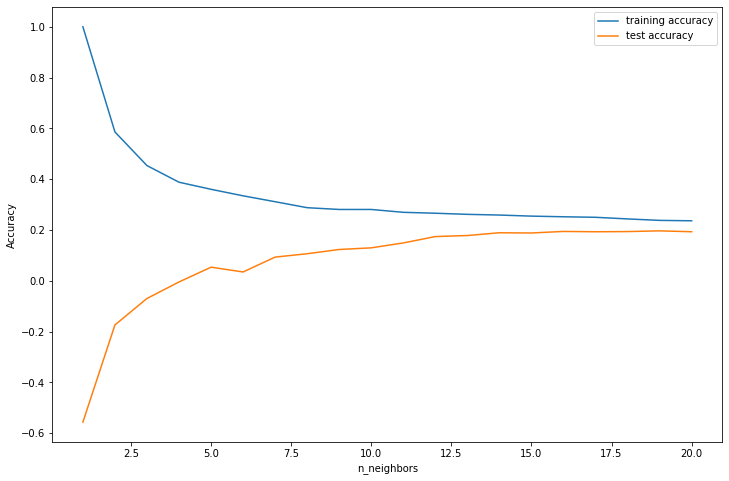

The optimal number of neighbors is: 19


In [25]:
# Using the KNN Method:

# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(X_data = X_train,
                                  y_data = y_train)

In [26]:
# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test_scaled)


# train accuracy
knn_train_acc = knn_fit.score(X_train_scaled, y_train_scaled).round(4)

# test accuracy
knn_test_acc  = knn_fit.score(X_test_scaled, y_test_scaled).round(4)

# auc value
knn_auc       = roc_auc_score(y_true  = y_test_scaled,
                              y_score = knn_pred).round(4)

# saving the results
model_performance.append(['KNN Classification',
                          knn_train_acc,
                          knn_test_acc,
                          knn_auc])

*Designing a Confusion Matrix to see how many predictions have been falsely classified:*

<u>From this, we can see that the numbers of the falsely classified data are not too high, but have room for improvement.</u>

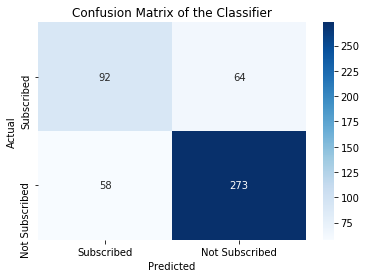

In [27]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Subscribed', 'Not Subscribed'])

*Running a Decision Tree Classifier:*

In [28]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(X_train_scaled, y_train_scaled)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(X_test_scaled)


# train accuracy
full_tree_train_acc = full_tree_fit.score(X_train_scaled, y_train_scaled).round(4)

# test accuracy
full_tree_test_acc  = full_tree_fit.score(X_test_scaled, y_test_scaled).round(4)

# auc value
full_tree_auc       = roc_auc_score(y_true  = y_test_scaled,
                                    y_score = full_tree_pred).round(4)


# saving the results
model_performance.append(['Full Tree',
                          full_tree_train_acc,
                          full_tree_test_acc,
                          full_tree_auc])

*Running a Decision Tree Classifier by specifying parameters*

In [29]:
# INSTANTIATING a Decision Tree Classifier object, but with specific parameters this time
tree_pruned = DecisionTreeClassifier(max_depth = 3,
                      random_state = 222)


# FITTING the training data
tree_pruned_fit = tree_pruned.fit(X_train_scaled, y_train_scaled)


# PREDICTING on new data
tree_pruned_pred = tree_pruned_fit.predict(X_test_scaled)


# train accuracy
p_tree_train_acc = tree_pruned_fit.score(X_train_scaled, y_train_scaled).round(4)

# test accuracy
p_tree_test_acc  = tree_pruned_fit.score(X_test_scaled, y_test_scaled).round(4)

# auc value
p_tree_auc       = roc_auc_score(y_true  = y_test_scaled,
                                 y_score = tree_pruned_pred).round(4)


# saving the results
model_performance.append(['Pruned Tree',
                          p_tree_train_acc,
                          p_tree_test_acc,
                          p_tree_auc])

*Using the user-defined function plot_feature_importance to check which features show as important:*

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:198: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


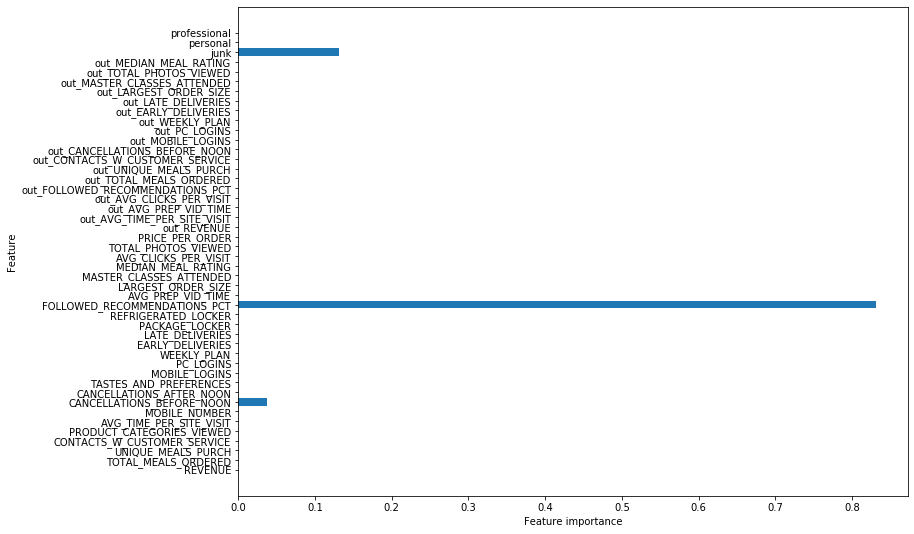

In [30]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

*Running a Random Forest Classifier and then hyperparameter tuning the model:*

In [31]:
"""
from sklearn.model_selection import GridSearchCV        # hyperparameter tuning
from sklearn.metrics import make_scorer                 # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = "gini", 
                                    max_depth        = None,
                                    min_samples_leaf = 1,
                                    bootstrap        = True, 
                                    warm_start       = False,
                                    random_state     = 222)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test_scaled)

# declaring model performance objects
rf_train_acc = rf_default_fit.score(X_train_scaled, y_train_scaled).round(4)
rf_test_acc  = rf_default_fit.score(X_test_scaled, y_test_scaled).round(4)
rf_auc       = roc_auc_score(y_true  = y_test_scaled,
                             y_score = rf_default_fit_pred).round(4)


# appending to model_performance
model_performance.append(['Random Forest',
                            rf_train_acc,
                            rf_test_acc,
                            rf_auc])
"""

'\nfrom sklearn.model_selection import GridSearchCV        # hyperparameter tuning\nfrom sklearn.metrics import make_scorer                 # customizable scorer\nfrom sklearn.ensemble import RandomForestClassifier     # random forest\nfrom sklearn.ensemble import GradientBoostingClassifier # gbm\n\n# INSTANTIATING a random forest model with default values\nrf_default = RandomForestClassifier(n_estimators     = 100,\n                                    criterion        = "gini", \n                                    max_depth        = None,\n                                    min_samples_leaf = 1,\n                                    bootstrap        = True, \n                                    warm_start       = False,\n                                    random_state     = 222)\n\n# FITTING the training data\nrf_default_fit = rf_default.fit(X_train_scaled, y_train_scaled)\n\n\n# PREDICTING based on the testing set\nrf_default_fit_pred = rf_default_fit.predict(X_test_scaled)\n\n# de

In [32]:
"""
# Hyperparameter tuning for Random Forest Classifier

# declaring a hyperparameter space
estimator_space  = pd.np.arange(100, 1100, 250)
leaf_space       = pd.np.arange(1, 31, 10)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
full_forest_grid = RandomForestClassifier(random_state = 222)


# GridSearchCV object
full_forest_cv = GridSearchCV(estimator  = full_forest_grid,
                              param_grid = param_grid,
                              cv         = 3,
                              scoring    = make_scorer(roc_auc_score,
                                           needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
full_forest_cv.fit(original_df_data, original_df_response)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", full_forest_cv.best_params_)
print("Tuned Training AUC:", full_forest_cv.best_score_.round(4))


# RESULTS:

Tuned Parameters  : {'bootstrap': False, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 100, 'warm_start': True}
Tuned Training AUC: 0.5886
"""

'\n# Hyperparameter tuning for Random Forest Classifier\n\n# declaring a hyperparameter space\nestimator_space  = pd.np.arange(100, 1100, 250)\nleaf_space       = pd.np.arange(1, 31, 10)\ncriterion_space  = [\'gini\', \'entropy\']\nbootstrap_space  = [True, False]\nwarm_start_space = [True, False]\n\n\n# creating a hyperparameter grid\nparam_grid = {\'n_estimators\'     : estimator_space,\n              \'min_samples_leaf\' : leaf_space,\n              \'criterion\'        : criterion_space,\n              \'bootstrap\'        : bootstrap_space,\n              \'warm_start\'       : warm_start_space}\n\n\n# INSTANTIATING the model object without hyperparameters\nfull_forest_grid = RandomForestClassifier(random_state = 222)\n\n\n# GridSearchCV object\nfull_forest_cv = GridSearchCV(estimator  = full_forest_grid,\n                              param_grid = param_grid,\n                              cv         = 3,\n                              scoring    = make_scorer(roc_auc_score,\n   

In [33]:
"""
# INSTANTIATING the Random Forest Classifier model object WITH hyperparameters
rf_tuned = RandomForestClassifier(bootstrap             = False,
                                       criterion        = 'entropy',
                                       min_samples_leaf = 1,
                                       n_estimators     = 100,
                                       warm_start       = True,
                                       random_state     = 222)


# FIT step is needed as we are not using .best_estimator
rf_tuned_fit = rf_tuned.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
rf_tuned_pred = rf_tuned_fit.predict(X_test_scaled)

# declaring model performance objects
rf_train_acc_tuned = rf_tuned_fit.score(X_train_scaled, y_train_scaled).round(4)
rf_test_acc_tuned  = rf_tuned_fit.score(X_test_scaled, y_test_scaled).round(4)
rf_auc_tuned       = roc_auc_score(y_true  = y_test_scaled,
                             y_score = rf_tuned_pred).round(4)


# appending to model_performance
model_performance.append(['Tuned Random Forest',
                          rf_train_acc_tuned,
                          rf_test_acc_tuned,
                          rf_auc_tuned])
"""

"\n# INSTANTIATING the Random Forest Classifier model object WITH hyperparameters\nrf_tuned = RandomForestClassifier(bootstrap             = False,\n                                       criterion        = 'entropy',\n                                       min_samples_leaf = 1,\n                                       n_estimators     = 100,\n                                       warm_start       = True,\n                                       random_state     = 222)\n\n\n# FIT step is needed as we are not using .best_estimator\nrf_tuned_fit = rf_tuned.fit(X_train_scaled, y_train_scaled)\n\n\n# PREDICTING based on the testing set\nrf_tuned_pred = rf_tuned_fit.predict(X_test_scaled)\n\n# declaring model performance objects\nrf_train_acc_tuned = rf_tuned_fit.score(X_train_scaled, y_train_scaled).round(4)\nrf_test_acc_tuned  = rf_tuned_fit.score(X_test_scaled, y_test_scaled).round(4)\nrf_auc_tuned       = roc_auc_score(y_true  = y_test_scaled,\n                             y_score = rf_t

*Running a Gradient Booster and then hyperparameter tuning the model:*

In [34]:
# INSTANTIATING the GradientBoosting model object without hyperparameters
gbm_default = GradientBoostingClassifier(     loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = "friedman_mse",
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 222)


# FIT step is needed as we are not using .best_estimator
gbm_default_fit = gbm_default.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
gbm_default_pred = gbm_default_fit.predict(X_test_scaled)


# declaring model performance objects
gbm_train_acc = gbm_default_fit.score(X_train_scaled, y_train_scaled).round(4)
gbm_test_acc  = gbm_default_fit.score(X_test_scaled, y_test_scaled).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test_scaled,
                                          y_score = gbm_default_pred).round(4)


# appending to model_performance
model_performance.append(['Gradient Boosting Model',
                           gbm_train_acc,
                           gbm_test_acc,
                           gbm_auc])

In [35]:
"""
# Hyperparameter tuning for Gradient Boosting Classifier

# declaring a hyperparameter space
learn_space     = pd.np.arange(0.1, 1.6, 0.3)
estimator_space = pd.np.arange(50, 250, 50)
depth_space     = pd.np.arange(1, 10)


# creating a hyperparameter grid
param_grid = {'learning_rate' : learn_space,
              'max_depth'     : depth_space,
              'n_estimators'  : estimator_space}


# INSTANTIATING the model object without hyperparameters
gbm_grid = GradientBoostingClassifier(random_state = 222)


# GridSearchCV object
gbm_cv = GridSearchCV(     estimator  = gbm_grid,
                           param_grid = param_grid,
                           cv         = 3,
                           scoring    = make_scorer(roc_auc_score,
                                        needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
gbm_cv.fit(X_train_scaled, y_train_scaled)


# printing the optimal parameters and best score
print("Tuned Parameters  :", gbm_cv.best_params_)
print("Tuned Training AUC:", gbm_cv.best_score_.round(4))


# RESULTS:

#Tuned Parameters  : {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
#Tuned Training AUC: 0.7668

"""

'\n# Hyperparameter tuning for Gradient Boosting Classifier\n\n# declaring a hyperparameter space\nlearn_space     = pd.np.arange(0.1, 1.6, 0.3)\nestimator_space = pd.np.arange(50, 250, 50)\ndepth_space     = pd.np.arange(1, 10)\n\n\n# creating a hyperparameter grid\nparam_grid = {\'learning_rate\' : learn_space,\n              \'max_depth\'     : depth_space,\n              \'n_estimators\'  : estimator_space}\n\n\n# INSTANTIATING the model object without hyperparameters\ngbm_grid = GradientBoostingClassifier(random_state = 222)\n\n\n# GridSearchCV object\ngbm_cv = GridSearchCV(     estimator  = gbm_grid,\n                           param_grid = param_grid,\n                           cv         = 3,\n                           scoring    = make_scorer(roc_auc_score,\n                                        needs_threshold = False))\n\n\n# FITTING to the FULL DATASET (due to cross-validation)\ngbm_cv.fit(X_train_scaled, y_train_scaled)\n\n\n# printing the optimal parameters and best s

In [36]:
# INSTANTIATING the GradientBoostingClassifier model object WITH hyperparameters
gbm_tuned = GradientBoostingClassifier(learning_rate = 0.1,
                                       max_depth     = 1,
                                       n_estimators  = 100,
                                       random_state  = 222)


# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(X_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(X_test_scaled)


gbm_train_acc_tuned = gbm_tuned_fit.score(X_train_scaled, y_train_scaled).round(4)
gbm_test_acc_tuned  = gbm_tuned_fit.score(X_test_scaled, y_test_scaled).round(4)
gbm_auc_tuned       = roc_auc_score(y_true  = y_test_scaled,
                                          y_score = gbm_tuned_pred).round(4)

# appending to model_performance
model_performance.append(['Tuned Gradient Boosting Model',
                          gbm_train_acc_tuned,
                          gbm_test_acc_tuned,
                          gbm_auc_tuned])

*Running an ADA Boost Classifier:*

In [37]:
"""
# Instantiate ADA
ada = AdaBoostClassifier(base_estimator = tree_pruned,
                         n_estimators   = 300,
                         random_state   = 222,
                         learning_rate  = 1)

# Fit ADA to the training set
ada_fit = ada.fit(X_train_scaled, y_train_scaled)

# Compute the probabilities of obtaining the positive class
y_pred = ada.predict(X_test_scaled)
ada_roc_auc = roc_auc_score(y_test_scaled, y_pred)


ada_train = ada.score(X_train_scaled, y_train_scaled).round(2)
ada_test = ada.score(X_test_scaled, y_test_scaled).round(2)
ada_roc_auc = roc_auc_score(y_test_scaled, y_pred).round(2)

# appending to model_performance
model_performance.append(['ADA Model',
                          ada_train,
                          ada_test,
                          ada_roc_auc])
"""

"\n# Instantiate ADA\nada = AdaBoostClassifier(base_estimator = tree_pruned,\n                         n_estimators   = 300,\n                         random_state   = 222,\n                         learning_rate  = 1)\n\n# Fit ADA to the training set\nada_fit = ada.fit(X_train_scaled, y_train_scaled)\n\n# Compute the probabilities of obtaining the positive class\ny_pred = ada.predict(X_test_scaled)\nada_roc_auc = roc_auc_score(y_test_scaled, y_pred)\n\n\nada_train = ada.score(X_train_scaled, y_train_scaled).round(2)\nada_test = ada.score(X_test_scaled, y_test_scaled).round(2)\nada_roc_auc = roc_auc_score(y_test_scaled, y_pred).round(2)\n\n# appending to model_performance\nmodel_performance.append(['ADA Model',\n                          ada_train,\n                          ada_test,\n                          ada_roc_auc])\n"

<strong> Comparing the different models and picking the optimal model: </strong>

In [38]:
# Final comparison of model performances:

# declaring a DataFrame object
model_performance_df = pd.DataFrame(model_performance[1:], columns = model_performance[0])

model_performance_df

,Model,Training Accuracy,Testing Accuracy,AUC Value
0,Logistic Regression,0.7800,0.7495,0.7073
1,KNN Classification,0.7553,0.7351,0.6306
2,Full Tree,1.0000,0.7023,0.6590
3,Pruned Tree,0.7772,0.7659,0.7820
4,Gradient Boosting Model,0.8924,0.7639,0.7399
5,Tuned Gradient Boosting Model,0.8101,0.7864,0.7565


<strong> The winner is the Pruned Decison Tree Classifier! So here's how the decision tree looks when it comes to determining the factors that are likely to result in the success of the 'Halfway There' promotion campaign.. </strong>

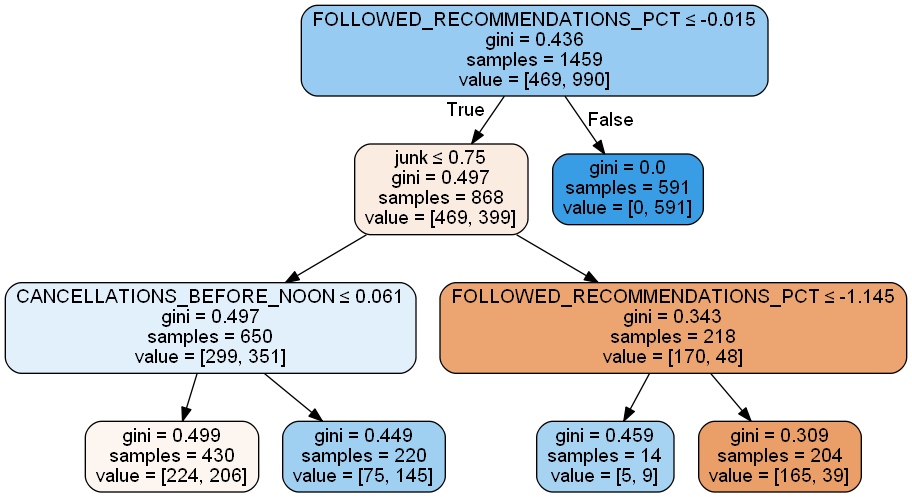

In [39]:
# calling display_tree on my best model: Pruned Tree

display_tree(tree       = tree_pruned,
             feature_df = X_train,
             height = 500,
             width  = 800)